# Reproduce issue 7901

https://github.com/pymc-devs/pymc/issues/7901

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
import pymc as pm
import pytensor

print(f"Running on PyMC v{pm.__version__}")
print(f"Running on PyTensor v{pytensor.__version__}")

Running on PyMC v5.26.1
Running on PyTensor v2.35.1


In [3]:
import sys
sys.platform, sys.version

('darwin',
 '3.12.4 (v3.12.4:8e8a4baf65, Jun  6 2024, 17:33:18) [Clang 13.0.0 (clang-1300.0.29.30)]')

## Case study 1: Educational Outcomes for Hearing-impaired Children

In [4]:
test_scores = pd.read_csv(pm.get_data("test_scores.csv"), index_col=0)
test_scores.head()

,score,male,siblings,family_inv,non_english,prev_disab,age_test,non_severe_hl,mother_hs,early_ident,non_white
0,40,0,2.0,2.0,False,NaN,55,1.0,NaN,False,False
1,31,1,0.0,NaN,False,0.0,53,0.0,0.0,False,False
2,83,1,1.0,1.0,True,0.0,52,1.0,NaN,False,True
3,75,0,3.0,NaN,False,0.0,55,0.0,1.0,False,False
5,62,0,0.0,4.0,False,1.0,50,0.0,NaN,False,False


In [5]:
# Dropping missing values is a very bad idea in general, but we do so here for simplicity
X = test_scores.dropna().astype(float)
y = X.pop("score")

# Standardize the features
X -= X.mean()
X /= X.std()

N, D = X.shape

D0 = int(D / 2)

In [6]:
import pytensor.tensor as pt

with pm.Model(coords={"predictors": X.columns.values}) as test_score_model:
    # Prior on error SD
    sigma = pm.HalfNormal("sigma", 25)

    # Global shrinkage prior
    tau = pm.HalfStudentT("tau", 2, D0 / (D - D0) * sigma / np.sqrt(N))
    # Local shrinkage prior
    lam = pm.HalfStudentT("lam", 5, dims="predictors")
    c2 = pm.InverseGamma("c2", 1, 1)
    z = pm.Normal("z", 0.0, 1.0, dims="predictors")
    # Shrunken coefficients
    beta = pm.Deterministic(
        "beta", z * tau * lam * pt.sqrt(c2 / (c2 + tau**2 * lam**2)), dims="predictors"
    )
    # No shrinkage on intercept
    beta0 = pm.Normal("beta0", 100, 25.0)

    scores = pm.Normal("scores", beta0 + pt.dot(X.values, beta), sigma, observed=y.values)

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: random_make_inplace
ERROR (pytensor.graph.rewriting.basic): node: t_rv{"(),(),()->()"}(*0-<RandomGeneratorType>, *1-<NoneTypeT>, *2-<Scalar(int8, shape=())>, 0.0, *3-<Scalar(float64, shape=())>)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/ivan/Projects/Minireference/STATSbook/noBSstats/venv/lib/python3.12/site-packages/pytensor/graph/rewriting/basic.py", line 1920, in process_node
    replacements = node_rewriter.transform(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/ivan/Projects/Minireference/STATSbook/noBSstats/venv/lib/python3.12/site-packages/pytensor/graph/rewriting/basic.py", line 993, in transform
    return self.fn(fgraph, node)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/Users/ivan/Projects/Minireference/STATSbook/noBSstats/venv/lib/python3.12/site-packages/pytensor/tensor/random/rewriting/basic.py", line

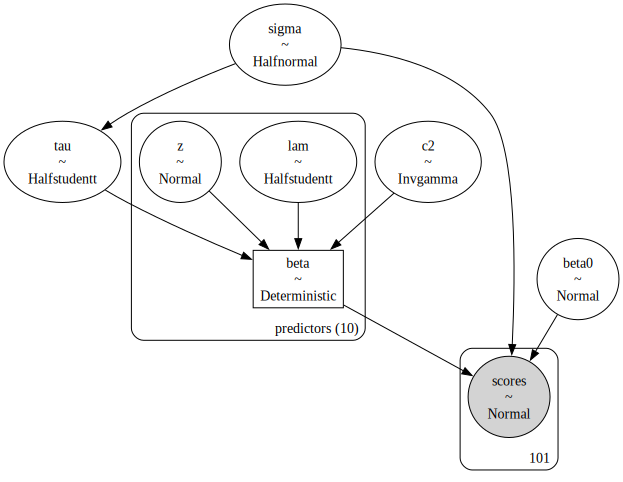

In [7]:
pm.model_to_graphviz(test_score_model)